In this notebook, I will use a more traditional C++ style of reading a CSV file to read in earthquake data and then calculate the Gutenberg-Richter curve. Notice how different this appears to the pandas style of reading data. 

As with the Mapping notebook, the first step is to load the libraries that will be used.

In [3]:
import csv
import sys
import numpy as np
import matplotlib 
from matplotlib import pylab as py

As with the other notebook, stylistically I like to put all my constant variables in the first part of the code. This is a style choice rather than a necessary choice. 

In [13]:
#First set the file with the earthquake data
file_full = "PRSNCAT2004_2018"
#next some variables for the calculation
# minmag is the minimum magnitude to use in the calculation in G-R this is usually the magnitude that there is 
# catalog completeness.
minmag = 2.7

#The numyear is a flag that either says treat the data set as a whole (1) or get an annulized G-R curve by replacing 
# the 1 with the number of years of data used.
numyear = 15
#This denotes the column that contains the magnitudes. Note in C the count starts at 0 so here the 9 indicates that 
#the information is in the 10th column
mag_column_num = 9


The next step is to open the file and load the data. This will be more complicated than the map pandas example. Here we are using the C++ style. 
    1. Open the file
    2. Read the data
    3. Convert the number which is read in like text to a float (aka a number with decimal points)
    4. Store that data in an array (like a column in Excel)
    5. Close the file

In [14]:
#Step 1 open the file
token = open(file_full,'r',)
# Tell the computer to read the file line by line
linestoken = token.readlines()
#initiate arrays to store the text data and numerical version of the data
mag = []
mag2 =[]
#Tell the computer to perform the conversion line by line
for x in linestoken:
#For each line split the information into columns using , as a delimiter
    parts = x.split(',')
#Try converting the value in the magnitude column to a float number
    try:
        mag=float(parts[mag_column_num])
#If the conversion fails, don't use that lineand continue to the next line
    except:
        print("Magnitude not converted...skipping")
#put the converted data into an array for further calculations
    mag2.append(mag)
#close the file when you are finished
token.close()


Magnitude not converted...skipping
Magnitude not converted...skipping


The next step is to prepare the data for the calculation

In [15]:
# Get the total number of Earthquakes
numall = len(mag2)
# Now find out how many earthquakes are greater than the min magnitude and save those in a separate array
used_mag = [i for i in mag2 if i>minmag]
numused = len(used_mag)
# Print out some info on the screen
print('Number of Earthquakes Used:',  numused)
print('Minimum Magnitude:' , minmag)
# Set Maximum Magnitude for the statistical work based on the data 
#Also create the bins for the histograms
max_mag = max(used_mag)
maxbin = max_mag + 0.05
bin_int = 0.05
# create Magnitude bins
bins = np.arange(minmag,maxbin, bin_int)
#make bins for plotting
plotbins = np.arange(minmag,max_mag,bin_int)


Number of Earthquakes Used: 21888
Minimum Magnitude: 2.7


Now let's plot some earthquake statistics!

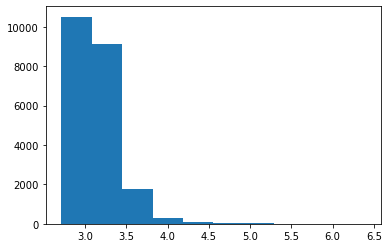

<Figure size 576x576 with 0 Axes>

In [16]:
# MAKE the HISTOGRAM!
#############################################################
counts, bin2s = np.histogram(used_mag)
py.hist(bin2s[:-1], bin2s, weights=counts)
fig = py.figure(figsize=(8,8))
hist=np.histogram(used_mag,bins=bins)
##Reverse the array order for cummulative plot
hist=hist[0][::-1]
bins=bins[::-1]



Now let's calculate the cummulative curve

In [17]:
# Calculate the cummulative curve
#########################################################
cum_hist = hist.cumsum()
bins = bins[1:]
# And calculate the log base 10 for the data
log_cum_hist= np.where(cum_hist != 0 , np.log10(cum_hist), 0)



<ipython-input-17-176f1673bd94>:6: RuntimeWarning: divide by zero encountered in log10
  log_cum_hist= np.where(cum_hist != 0 , np.log10(cum_hist), 0)


There are two different ways to calculate the b value for a G-R curve. The least squares method or the maximum likelihood method. For best results I prefer to calculate both. 

In [19]:
# Use least squares to fit the data to calculate the a, b values
# Calculates for both full and annual rates
########################################################

b,a = np.polyfit(bins, log_cum_hist,1)
print('Least Squares b Value:', "%2.2f"% (-1.*b))
        
#   Calculate in terms of annual productivity if selected
if numyear != 1:
    print('Calculate annual rate selected!')
    cum_hist2=np.true_divide(cum_hist, numyear)
    log_cum_hist_ann= np.where(cum_hist2 != 0 , np.log10(cum_hist2), 0)
    b_ann,a_ann = np.polyfit(bins, log_cum_hist_ann,1)
    print('Least Squares Annual b Value:' "%2.2f"% (-1.*b_ann))
       
######################################################
# Now Calculate using Maximum Likelyhood estimate fit
######################################################

b_ml= np.log10(np.exp(1))/(np.mean(used_mag)-minmag)
print('Maximum Likelihood b value:', "%2.2f"% (b_ml))
ml_fit = -1.0 * b_ml *plotbins + 1.0*b_ml*minmag +np.log10(numused)


Least Squares b Value: 1.30
Calculate annual rate selected!
Least Squares Annual b Value:1.18
Maximum Likelihood b value: 1.02


<ipython-input-19-f4696a5298df>:12: RuntimeWarning: divide by zero encountered in log10
  log_cum_hist_ann= np.where(cum_hist2 != 0 , np.log10(cum_hist2), 0)


Finally, Let's plot the results using matplotlib. 

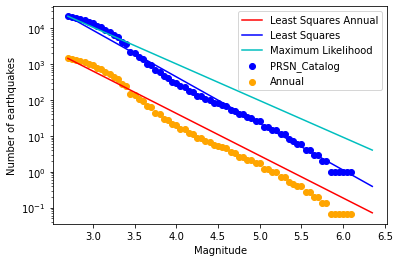

In [32]:
# Now to make some plots of the results
#####################################################

# First we need some data and convert value to log for plotting the fit line
#
# Prep for Least squares solution
#y intercept
yint = log_cum_hist[-1]-b*minmag
# least squares fit line full
ls_line = b*plotbins +yint
ls_line_plot = np.power(10,ls_line)

# Prep for Least squares solution annual rate
#y intercept
if numyear != 1:
    yint_ann = log_cum_hist_ann[-1]-b_ann*minmag
# least squares fit line full
    ls_line_ann = b_ann*plotbins +yint_ann
    ls_line_plot_ann = np.power(10,ls_line_ann)

###We also need to do the prep work for the Maximum likelihood method
# ML line 

ml_fit_plot = np.power(10,ml_fit)


# Plot Least squares results

ax = py.gca()
ax.scatter(bins, cum_hist, c='b', label = 'PRSN_Catalog')
if numyear != 1:
    ax.scatter(bins, cum_hist2, c='orange',label = 'Annual')
    ax.plot(plotbins, ls_line_plot_ann, c='r', label= 'Least Squares Annual')
ax.plot(plotbins, ls_line_plot, c='b', label= 'Least Squares')
ax.plot(plotbins, ml_fit_plot, c='c', label= 'Maximum Likelihood')
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('Number of earthquakes')
ax.set_xlabel('Magnitude')

py.show()

